In [1]:
import pandas as pd
import math
import numpy as np
import geopandas as gpd
import matplotlib.pyplot  as plt
import json
import pickle
from multiprocessing import Pool, cpu_count
from functools import partial

import os

from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping

In [2]:
pd.set_option('mode.chained_assignment', None)
threads = cpu_count()
threads

16

In [3]:
from pathlib  import Path
data_path = Path('./row_data')
files = {'grid':'trentino-grid.geojson',                                # dati poligonali geografici
         'adm_reg':'administrative_regions_Trentino.json',              # regioni amministrative
        'weather':'meteotrentino-weather-station-data.json',            # dati meteo
        'precip':'precipitation-trentino1.csv',                          # dati precipitazioni
        'precip-avail':'precipitation-trentino-data-availability1.csv',  # disponibilità dati precipitazioni
        'SET-1':'SET-nov-2013.csv',                                     # dataset consumi per linea, novemnbre
        'SET-2':'SET-dec-2013.csv',                                     # dataset consumi per linea, dicembre
        'SET-lines':'line.csv',                                         # linee elettriche su griglia (vedi primo set)
        'twitter':'social-pulse-trentino.geojson',                      # dati tweets
        'ISTAT':'R04_11_WGS84.shp',                                     # dati su tipo di posto e località
        'appa':'APPA_inquinamento_aria_Nov_Dec_2013.csv'}               # dati inquinamento per zona nel tempo su novembre 
                                                                        # e dicembre
    

os.getcwd()

'C:\\Users\\anank\\OneDrive\\PROGETTO BOSCHETTO\\notebooks'

In [4]:
# molte delle funzioni che vengono usate nello script


def SplitDate(df):
    week = {0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'}
    
    df['year']=df['DATA'].apply(lambda x:x[0:4])
    df['month']=df['DATA'].apply(lambda x:x[5:7])
    df['day']=df['DATA'].apply(lambda x:x[8:10])
    df['hour']=df['DATA'].apply(lambda x:x[11:13])
    df['minute']=df['DATA'].apply(lambda x:x[14:16])
    if df['month'][0]=='11':
        df['week']=df['day'].apply(lambda x:week[(int(x)+3)%7])
    elif df['month'][0]=='12':
        df['week']=df['day'].apply(lambda x:week[(int(x)+5)%7])
    
    df.drop(columns=['DATA', 'year'], inplace=True)
    df.month  = df.month.astype(np.dtype("int8"))
    df.day    = df.day.astype(np.dtype("int8"))
    df.hour   = df.hour.astype(np.dtype("int8"))
    df.minute = df.minute.astype(np.dtype("int8"))
    
    return df




def SplitDate2(df):
    week = {0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'}
    
    df['year']=df['DATA'].apply(lambda x:x[0:4])
    df['month']=df['DATA'].apply(lambda x:x[5:7])
    df['day']=df['DATA'].apply(lambda x:x[8:10])

    if df['month'][0]=='11':
        df['week']=df['day'].apply(lambda x:week[(int(x)+3)%7])
    elif df['month'][0]=='12':
        df['week']=df['day'].apply(lambda x:week[(int(x)+5)%7])
    
    df.drop(columns=['DATA', 'year'], inplace=True)
    df.month  = df.month.astype(np.dtype("int8"))
    df.day    = df.day.astype(np.dtype("int8"))
    df.hour   = df.hour.astype(np.dtype("int8"))
    
    return df





def SplitDate3(df):
    week = {0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'}
    
    df['year']=df['DATA'].apply(lambda x:x[0:4])
    df['month']=df['DATA'].apply(lambda x:x[4:6])
    df['day']=df['DATA'].apply(lambda x:x[6:8])
    df['hour']=df['DATA'].apply(lambda x:x[8:10])
    df['minute']=df['DATA'].apply(lambda x:x[10:12])
    if df['month'][0]=='11':
        df['week']=df['day'].apply(lambda x:week[(int(x)+3)%7])
    elif df['month'][0]=='12':
        df['week']=df['day'].apply(lambda x:week[(int(x)+5)%7])
    
    df.drop(columns=['DATA', 'year'], inplace=True)
    df.month  = df.month.astype(np.dtype("int8"))
    df.day    = df.day.astype(np.dtype("int8"))
    df.hour   = df.hour.astype(np.dtype("int8"))
    df.minute = df.minute.astype(np.dtype("int8"))
    return df



def microgrammi(x):
    y = x*10**(-6)
    return y

def milligrammi(x):
    y = x*10**(-3)
    return y

Carico i dati del consumo delle linee e la loro identificazione geografica

In [5]:
SET_1 = gpd.read_file(data_path / files['SET-1'])           # consumo linee elettriche novembre

SET_2 = gpd.read_file(data_path / files['SET-2'])           # consumo linee elettriche dicembre

SET = SET_1.append(SET_2, ignore_index=True)                # unisco set novembre e dicembre

del SET_1                                                   # faccio pulizia
del SET_2

SET.drop(columns = 'geometry', inplace=True)                # elimino campo vuoto
SET.rename(columns = {'field_1':'LINESET', 'field_2':'DATA', 'field_3':'CONSUMI'}, inplace=True) # rinomino colonne con 
                                                                                                 # grandezze rappresentate
SET = SET.astype({'CONSUMI': float})                        # imposto il tipo di dati per la colonna di consumi

SplitDate(SET)                                              # traduco la stringa di testo in 3 colonne (anno, mese, giorno 
                                                            # del mese)


SET = SET.groupby(['LINESET', 'month', 'day', 'hour', 'week'], as_index=False).sum().copy() # passo da risoluzione ogni 10
                                                                                            # minuti a risoluzione oraria
                                                                                            # (suppongo il dato sia kWh e
                                                                                            # non kW)

SET.drop(columns=['minute'], inplace=True)

SET_lines = gpd.read_file(data_path / files['SET-lines'])   # dati geografici delle linee elettriche: nome griglia e numero
                                                            # locazioni
    
SET_lines.drop(columns = ['geometry'], inplace=True)          # come sopra, elimino colonna vuota

SET_lines = SET_lines.astype({'NR_UBICAZIONI': int})        # imposto datatype per il numero di ubicazioni come int(ero)


df_grid = gpd.read_file(data_path / files['grid'])                  #importo dati griglia geografica: nome cella, forma,???

# gli aggiungo la colonna  con il centro
df_grid['center'] = df_grid['geometry'].apply(lambda x:x.centroid)  # aggiungo colonna con centroide, mi servirà dopo per 
                                                                    # valutare le distanze della cella dalla stazione meteo
    
SET

,LINESET,month,day,hour,week,CONSUMI
0,DG1000420,11,1,0,fri,215.639993
1,DG1000420,11,1,1,fri,202.679990
2,DG1000420,11,1,2,fri,191.339990
3,DG1000420,11,1,3,fri,191.879988
4,DG1000420,11,1,4,fri,188.099990
...,...,...,...,...,...,...
269371,DG1056626,12,31,19,sun,361.325005
269372,DG1056626,12,31,20,sun,427.875000
269373,DG1056626,12,31,21,sun,570.349999
269374,DG1056626,12,31,22,sun,516.649993


Ora faccio delle operazioni per associare i dati dei consumi per linea e i dati geografici per la linea. Siccome alcune linee elettriche coprono più celle e alcune celle contegono diverse lnee elettriche, faccio delle operazioni sul numero di ubicazioni. Assumo che il consumo elettrico per linea in ogni cella sia uniforme; calcolo quindi il conumo medio per ubicazione e poi divido il consumo per cella per linea usando questo dato.

In [6]:
POP_lineset = SET_lines.copy()                                  # copio dataset dati geografici + linea + popolazione

POP_lineset.drop(columns = 'SQUAREID', inplace = True)          # droppo i dati geografici perché voglio la popolazione
                                                                # della linea

POP_lineset = POP_lineset.groupby('LINESET', as_index=False).sum().copy()  # sommo la popolazione sulla linea: trovo
                                                                           # popolazione totale linea

# POP_lineset.drop(columns='minute', inplace=True)

POP_lineset['1/NR_UBICAZIONI'] = 1/POP_lineset['NR_UBICAZIONI'] # variabile ausiliaria per trovare i pesi da usare 
                                                                # sulle diverse squreid
    
POP_lineset.drop(columns = 'NR_UBICAZIONI', inplace = True)                # pulisco la colonna, non mi serve più

POP_lineset = POP_lineset.merge(SET_lines, how='right', on='LINESET')      # unisco il df ora creato con i consumi

POP_lineset['SQUAREID_DENS'] = POP_lineset['1/NR_UBICAZIONI']*POP_lineset['NR_UBICAZIONI'] # pesi da usare per 
                                                                                           # la suddivisone dei consumi 
                                                                                           # sulle squareid
        
consumi = SET.copy()                                            # creo copia del dataset dei consumi

TOTALE = POP_lineset.merge(consumi, how='left', on='LINESET')   # unisco il dataset con i dati geografici+pesi e quello 
                                                                # dei consumi. Ogni squareid, lineset consuma come
                                                                # tutto il lineset
    
TOTALE['CONSUMI'] = TOTALE['CONSUMI']*TOTALE['SQUAREID_DENS']   # applico i pesi trovati prima

TOTALE.drop(columns=['1/NR_UBICAZIONI', 'SQUAREID_DENS'], inplace=True) # butto via i pesi, non mi servono più

TOTALE.rename(columns={'SQUAREID':'cellId'}, inplace=True)       # rinomino la colonna delle celle geografiche
                                                                 # in modo che sia compatible col prossimo dataset

TOTALE.cellId = TOTALE.cellId.astype(np.dtype("int16"))          # cambio il datatype in modo da ridurre le dimensioni 
                                                                 # in memoria (prima era int64)
    
TOTALE.NR_UBICAZIONI = TOTALE.NR_UBICAZIONI.astype(np.dtype("int16"))   # stessa cosa, qui era int32


TOTALE.dropna(subset=['month'], inplace=True)                     # elimino cellid subito fuori al confine, di cui 
                                                                  # non ho dati

TOTALE.month = TOTALE.month.astype(np.dtype("int8"))              # converto da str a int8 gli elementi della data
TOTALE.day = TOTALE.day.astype(np.dtype("int8"))
TOTALE.hour = TOTALE.hour.astype(np.dtype("int8"))



TOTALE

,LINESET,cellId,NR_UBICAZIONI,month,day,hour,week,CONSUMI
0,DG1031221,155,4,11,1,0,fri,0.543304
1,DG1031221,155,4,11,1,1,fri,0.453565
2,DG1031221,155,4,11,1,2,fri,0.466783
3,DG1031221,155,4,11,1,3,fri,0.437217
4,DG1031221,155,4,11,1,4,fri,0.442435
...,...,...,...,...,...,...,...,...
3705423,DG1013503,11099,3,12,31,19,sun,0.807393
3705424,DG1013503,11099,3,12,31,20,sun,0.681264
3705425,DG1013503,11099,3,12,31,21,sun,0.645372
3705426,DG1013503,11099,3,12,31,22,sun,0.583070


Ora ho i consumi associati ad ogni linea e squareid.
Carico il dataset con i dati geometrici per ogni squareid e dopo lo associo.

In [7]:
SET_geo = df_grid.copy()                                        # creo copia del dataset su cui lavorare
                                                            
SET_geo.cellId = SET_geo.cellId.astype(np.dtype("int16"))       # converto il nome delle cellId nello stesso tipo 
                                                                # dell'altro df



SET_geo_tot = SET_geo.merge(TOTALE, how='right', on='cellId')   # fondo i df in modo da ottenere un df con tutte 
                                                                # le informazioni



SET_geo_tot

,cellId,geometry,center,LINESET,NR_UBICAZIONI,month,day,hour,week,CONSUMI
0,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,0,fri,0.543304
1,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,1,fri,0.453565
2,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,2,fri,0.466783
3,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,3,fri,0.437217
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,4,fri,0.442435
...,...,...,...,...,...,...,...,...,...,...
3705379,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,19,sun,0.807393
3705380,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,20,sun,0.681264
3705381,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,21,sun,0.645372
3705382,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,22,sun,0.583070


Carico ora un dataset dell'ISTAT che classifica le località del Trentino-Alto Adige in 4 tipologie:

* **tipo 1**: centro abitato
* **tipo 2**: nucleo abitato
* **tipo 3**: zona produttiva
* **tipo 4**: case sparse

Contiene inoltre informazioni sulle località, per cui poi lo userò per trovare le celle associate ad alcune località di interesse.

,PRO_COM,SEZ,COD_LOC,TIPO_LOC,Shape_Area,geometry
0,22006,40,10001,1,39288.700138,"POLYGON ((10.86651 45.92331, 10.86629 45.92284..."
1,22006,68,10001,1,18964.885179,"POLYGON ((10.86181 45.91841, 10.85930 45.91647..."
2,22006,81,10001,1,32845.318890,"POLYGON ((10.87938 45.91142, 10.87862 45.91180..."
3,22006,55,40001,4,222756.398876,"POLYGON ((10.88496 45.91239, 10.88471 45.91217..."
4,22006,12,10001,1,229417.344149,"POLYGON ((10.88286 45.91943, 10.88258 45.91888..."
...,...,...,...,...,...,...
11707,21046,49,26609,2,25010.671200,"POLYGON ((10.50868 46.70215, 10.50862 46.70174..."
11708,21049,22,26602,2,18569.070300,"POLYGON ((10.81277 46.57659, 10.81283 46.57601..."
11709,21049,4,26607,2,21465.953150,"POLYGON ((10.80179 46.57277, 10.80053 46.57232..."
11710,21049,6,26604,2,17306.766000,"POLYGON ((10.78317 46.57047, 10.78312 46.57014..."


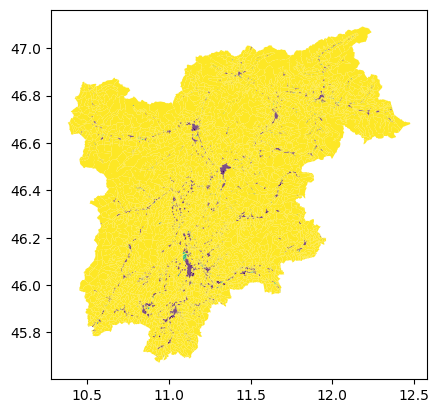

In [8]:
dat_amm = gpd.read_file(files['ISTAT'])     # carico il file shapely

# elimino colonne di troppo
dat_amm.drop(columns=['ACE', 'COD_MONT_D', 'COM_ASC', 'COD_ASC', 'LOC2011', 'Shape_Leng', 'COD_REG', 'COD_IS_AMM', 'COD_ZONA_C', 'SEZ2011', 'COD_STAGNO', 'COD_FIUME', 'COD_LAGO', 'COD_LAGUNA', 'COD_IS_LAC', 'COD_IS_MAR', 'COD_AREA_S', 'COD_VAL_P', 'COD_ISTAT'], inplace=True)

dat_amm = dat_amm.to_crs(4326)              # riproietto correttamente i dati geografici

dat_amm.TIPO_LOC = dat_amm.TIPO_LOC.astype(np.dtype("int8"))    # trasformo da float a in8 per comodità e ragioni di memoria
dat_amm.PRO_COM = dat_amm.PRO_COM.astype(np.dtype("int32"))
dat_amm.SEZ = dat_amm.SEZ.astype(np.dtype("int32"))
dat_amm.COD_LOC = dat_amm.COD_LOC.astype(np.dtype("int32"))

elimina = [  851,  4075,  4192,  4330,  4448,  5388,  7253,  7263,      # alcuni identificativi salvati che sono fuori
           7952, 8765,  8881,  9255,  9584,  9701, 10757]               # regione e per cui mancano molte informazioni

dat_amm.plot('TIPO_LOC')
dat_amm

C:\Users\anank\.conda\envs\clone_trento_sociale\lib\site-packages\geopandas\array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,cellId,geometry,center,PRO_COM,SEZ,COD_LOC,TIPO_LOC
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",POINT (10.92089 45.67740),22007,53,40001,4
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",POINT (10.93372 45.67718),22007,36,40001,4
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",POINT (10.94655 45.67697),22007,36,40001,4
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",POINT (10.90836 45.68661),22007,53,40001,4
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),22007,53,40001,4
...,...,...,...,...,...,...,...
6555,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",POINT (11.81103 46.52301),22039,15,40005,4
6556,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",POINT (11.82405 46.52269),22039,15,40005,4
6557,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",POINT (11.79847 46.53232),22039,15,40005,4
6558,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",POINT (11.81149 46.53200),22039,15,40005,4


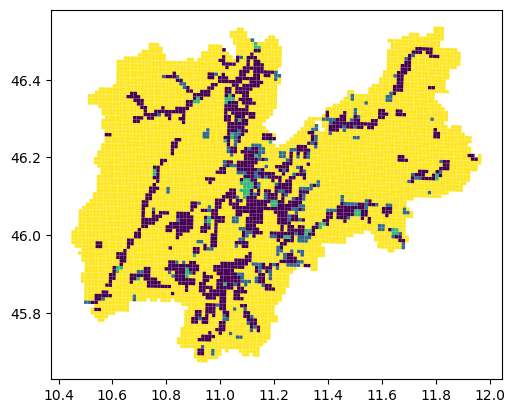

In [9]:
dati_amministrativi = dat_amm.copy()            # creo una copia del dataset dell'ISTAT

grid = df_grid.copy()                           # creo una copia del df con le informazioni sulle celle


gerarchia = (0, 2, 1, 3, 0)                     # creo un dizionario della priorità che voglio dare ai tipi di zona

lista_colonna_gerarchia = [gerarchia[xx] for xx in dati_amministrativi.TIPO_LOC]    # creo colonna da usare per filtro

dati_amministrativi['gerarchy'] = lista_colonna_gerarchia                           # la appendo


grid = grid[~grid['cellId'].isin(elimina)]      # elimino alcune colonne che sono fuori regione

dati_amministrativi = grid.sjoin_nearest(dati_amministrativi, how='left', max_distance=0.00001) # unisco i due df, con
                                                                                                # distanza massima
                                                                                                # impostata per escludere
                                                                                                # i dati fuori provincia

dati_amministrativi.drop(columns='index_right', inplace=True)       # elimino colonna dell'indice destro

dati_amministrativi.reset_index(drop=True, inplace=True)            # resetto l'indice

# creo una funzione che per ogni cella seleziona il TIPO_LOC con la gerarchia maggiore e poi a parità di TIPO_LOC tiene la
# località di area maggiore, in modo da avere un solo TIPO_LOC per ogni cellId
def Droppatore(df, cellina):
    tipo_max = max(df[(df.cellId==cellina)].gerarchy.unique())
    df.drop(df[((df.cellId==cellina)&(df.gerarchy<tipo_max))].index, inplace=True)
    area_max = max(df[(df.cellId==cellina)&(df.gerarchy==tipo_max)].Shape_Area.unique())
    df.drop(df[((df.cellId==cellina)&(df.Shape_Area<area_max))].index, inplace=True)

# La seguente pare commentata dovrebbe servire per parallelizzare il processo, ma non sembra funzionare (loop infinito?)

# def Droppatore1(cellina):
#     tipo_max = max(dati_amministrativi[(dati_amministrativi.cellId==cellina)].TIPO_LOC.unique())
#     dati_amministrativi.drop(dati_amministrativi[((dati_amministrativi.cellId==cellina)&(dati_amminis
# trativi.TIPO_LOC<tipo_max))].index, inplace=True)
#     area_max = max(dati_amministrativi[(dati_amministrativi.cellId==cellina)&(dati_amministrativi.TIPO
# _LOC==tipo_max)].Shape_Area.unique())
#     dati_amministrativi.drop(dati_amministrativi[((dati_amministrativi.cellId==cellina)&(dati_amminist
# rativi.Shape_Area<area_max))].index, inplace=True)


# if __name__ == '__main__':
#     inputs = [cella for cella in dati_amministrativi.cellId.unique()]
#     with Pool(threads) as p:
#         out = p.map(Droppatore1, inputs)



# applico la funzione ad ogni cella
for cella in dati_amministrativi.cellId.unique():
    Droppatore(dati_amministrativi, cella)


dati_amministrativi.reset_index(drop=True, inplace=True)                    # resetto indice di nuovo

dati_amministrativi.drop(columns=['gerarchy', 'Shape_Area'], inplace=True)  # butto via le colonne extra che
                                                                            # non servono più

dati_amministrativi.plot('TIPO_LOC')        # plotto il risultato

# grid.plot('cellId')                         # plotto la grglia
dati_amministrativi

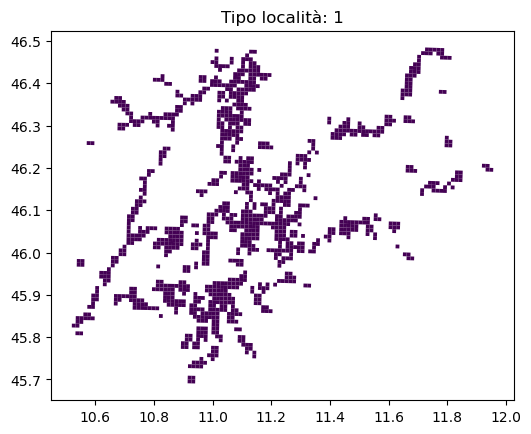

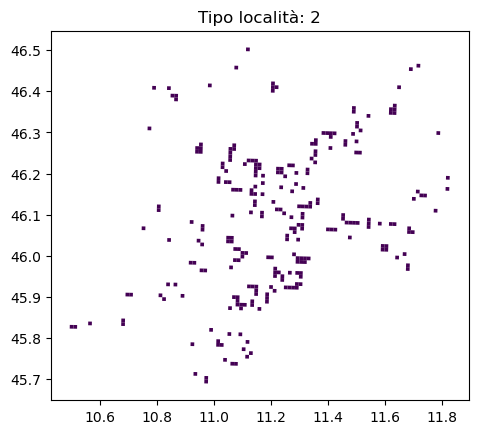

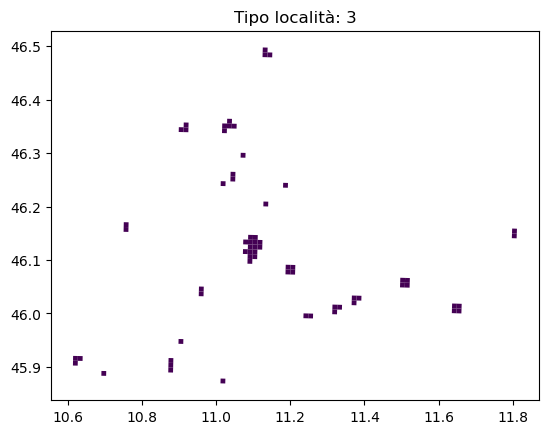

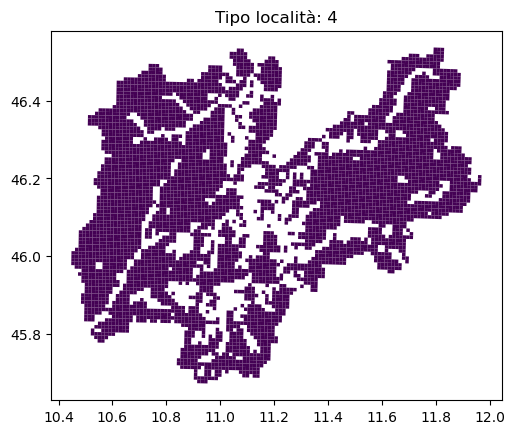

In [10]:
for ii in range(1, 5):
    ax = dati_amministrativi[dati_amministrativi.TIPO_LOC == ii].plot('TIPO_LOC')
    ax.set_title('Tipo località: '+str(ii))

In [11]:
consumi = SET_geo_tot.copy()
classificazione_zone = dati_amministrativi.copy()
classificazione_zone.drop(columns=['geometry', 'center'], inplace=True)

consumi = consumi.merge(classificazione_zone, how='left', on=['cellId'])

consumi.to_pickle('consumi_alberto.pkl')

consumi

,cellId,geometry,center,LINESET,NR_UBICAZIONI,month,day,hour,week,CONSUMI,PRO_COM,SEZ,COD_LOC,TIPO_LOC
0,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,0,fri,0.543304,22007,53,40001,4
1,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,1,fri,0.453565,22007,53,40001,4
2,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,2,fri,0.466783,22007,53,40001,4
3,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,3,fri,0.437217,22007,53,40001,4
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,4,fri,0.442435,22007,53,40001,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705379,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,19,sun,0.807393,22039,2,40001,4
3705380,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,20,sun,0.681264,22039,2,40001,4
3705381,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,21,sun,0.645372,22039,2,40001,4
3705382,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,22,sun,0.583070,22039,2,40001,4


Carico i dati meteo

In [12]:
with open(data_path / files['weather']) as f:                                   # carico il file
    weather_json = json.load(f)   

weather = gpd.GeoDataFrame(weather_json['features'])                            # credo il GeoDF

weather['geometry'] = weather['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
# traduco i dati geografici in dati poligonali

weather.drop(columns=['geomPoint.geom', 'timestamp'],inplace=True)              # droppo la colonna che ho trasformato

weather = weather[weather.columns.drop(list(weather.filter(regex='wind')))]     # elimino le colonne col vento, perché 
weather = weather[weather.columns.drop(list(weather.filter(regex='Wind')))]     # ci soni troppi dati mancanti e sono 
                                                                                # troppo localizzati perché siano utili
    
weather = weather[weather.columns.drop(list(weather.filter(regex='Temp')))]

weather

,station,elevation,date,precipitation,temperatures.0000,temperatures.0015,temperatures.0030,temperatures.0045,temperatures.0100,temperatures.0115,...,precipitations.2145,precipitations.2200,precipitations.2215,precipitations.2230,precipitations.2245,precipitations.2300,precipitations.2315,precipitations.2330,precipitations.2345,geometry
0,T0071,905,2013-11-01,False,8.4,8.3,8.2,8.1,8.2,8.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (10.79583 46.31340)
1,T0032,1155,2013-11-01,False,7.3,7.3,7.1,6.9,6.7,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (11.25372 45.94027)
2,T0096,1205,2013-11-01,False,8.2,8.2,8.1,8.1,8.1,8.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (11.66458 46.38364)
3,T0074,720,2013-11-01,False,10.2,10.2,10.1,10.1,10.1,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (10.91841 46.35160)
4,T0101,201,2013-11-01,False,12.8,12.7,12.9,12.6,12.4,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (11.07973 46.15635)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,T0431,1055,2013-12-31,False,-3.4,-3.5,-3.6,-3.9,-3.9,-3.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (11.33626 46.26304)
2191,T0428,525,2013-12-31,False,-0.4,0.3,-0.1,0.3,0.0,-0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (10.64241 45.94062)
2192,T0437,1465,2013-12-31,False,-8.3,-8.4,-8.3,-8.4,-8.1,-8.2,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (11.76685 46.47832)
2193,T0469,801,2013-12-31,False,-2.5,-2.6,-2.5,-2.7,-2.8,-2.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (11.62991 46.05718)


In [13]:
weather_ausiliario = weather.copy()                    # creo una copia del df meteo su cui lavorare
weather_ausiliario = weather_ausiliario[weather_ausiliario.columns.drop(list(weather_ausiliario.filter(regex='precipitation')))]

# creo una lista di stringhe con i minuti per poterci fare iterazioni e per manipolare il nome delle colonne
minuti_str = [str(x) for x in list(range(0, 60, 15))]  # trasformo gli elementi della lista 0, 15, 30, 45 in stringhe
minuti_str[0] = '0' + minuti_str[0]                    # il primo elemento è 0 ed è lungo 1 carattere, lo trasformo in 00

# faccio lo stesso con le ore, da 0 a 23
ore_str = [str(x) for x in list(range(24))]
#correzione per i valori da 0 a 9 che sono lunghi 1 carattere; da n a 0n
for i in range(10):
    ore_str[i] = '0'+ore_str[i]
    
# metto insieme le due stringhe di prima per avere un orario del formato 'oomm'
orario_str = []
for i in range(24):
    for j in range(4):
        orario_str.append(ore_str[i] + minuti_str[j])

# creo stringhe per la prima parte del nome delle colonne
nomicolonne =['temperatures.', 'precipitations.']

# passo da risoluzione ogni 15 minuti a ogni ora, facendo temperatura media; dopo droppo le colonne coi minuti
for ii in ore_str:
    weather_ausiliario[nomicolonne[0]+ii] = weather_ausiliario.loc[:, [nomicolonne[0]+ii+jj for jj in minuti_str]].mean(axis=1)

weather_ausiliario.drop(columns=[nomicolonne[0]+ii+jj for ii in ore_str for jj in minuti_str], inplace=True)


# tolgo l'altitudine perché in questo caso crea delle complicazioni
weather_ausiliario.drop(columns='elevation', inplace=True)

# creo lista di int da usare come colonna delle ore 
ore = [int(x) for x in range(24)]

# inizializzo variabili ausiliarie
lista_df = []

#per ogni stazione, creo un array con i dati come voglio io. Alla fine li meterò insieme in un unico df.
for ii in weather_ausiliario['station'].unique():
    ausiliario = weather_ausiliario[weather_ausiliario['station']==ii].copy()   # seleziono la stazione meteo e faccio una
                                                                                # copia con solo i dati di quella stazione
    
    ausiliario.drop(columns=['station', 'geometry'], inplace=True)              # elimino le colonne inutili della copia
    
    for jj in ausiliario['date'].unique():                                 
        ausiliario1 = ausiliario[ausiliario['date']==jj].copy()                 # seleziono per data e copio ancora
        
        ausiliario1.drop(columns=['date'], inplace=True)                        # butto via la colonna della data
        
        ausiliario1.reset_index(drop=True, inplace=True)                        # resetto l'indice
        
        ausiliario1 = ausiliario1.T                                             # traspongo la "matrice" in modo che
                                                                                # diventi 'verticale'
        
        ausiliario1['hour'] = ore                                               # aggiungo la colonna delle ore
        
        ausiliario1['DATA'] = jj                                                # aggiungo la data
        
        ausiliario1.rename(columns={0:'TEMPERATURA'}, inplace=True)             # siccome ho trasposto, la prima colonna 
                                                                                # si chiama 0 (l'indice). La rinomino.
            
        ausiliario1['station'] = ii                                             # aggiungo la stazione meteo
        
        ausiliario1.reset_index(drop=True, inplace=True)                        # resetto nuovamente l'indice
        
        lista_df.append(ausiliario1.copy())                                     # salvo l'oggetto in un array i cui
                                                                                # verranno uniti per diventare elementi
                                                                                # il gDF del meteo


meteo_ausiliario = gpd.GeoDataFrame()                                           # creo geodataframe ausiliario

notemp = weather_ausiliario.copy()                                              # copio la copia perché devo fare 
                                                                                # sui nomi delle colonne che poi non tengo

notemp.rename(columns={'date':'DATA'}, inplace=True)                            # cambio nome colonna per compatibilità con
                                                                                # funzione data
for ii in lista_df:
    meteo_ausiliario = meteo_ausiliario.append(ii, ignore_index=True)           # aggiungo i dati al gdf

notemp.drop(columns=[ii for ii in notemp.columns if 'temperature' in ii],inplace=True)  # elimino le colonne di troppo

meteo_temperature = meteo_ausiliario.merge(notemp, how='left', on=['station','DATA'])   # passaggio finale: unisco i dati
                                                                                        # per ottenere il risultato finale


SplitDate2(meteo_temperature)                                                   # trasformo data

meteo_temperature

,TEMPERATURA,hour,station,geometry,month,day,week
0,8.250,0,T0071,POINT (10.79583 46.31340),11,1,fri
1,8.200,1,T0071,POINT (10.79583 46.31340),11,1,fri
2,7.700,2,T0071,POINT (10.79583 46.31340),11,1,fri
3,7.525,3,T0071,POINT (10.79583 46.31340),11,1,fri
4,6.275,4,T0071,POINT (10.79583 46.31340),11,1,fri
...,...,...,...,...,...,...,...
52675,-7.950,19,T0450,POINT (11.79625 46.26160),12,31,sun
52676,-8.450,20,T0450,POINT (11.79625 46.26160),12,31,sun
52677,-8.625,21,T0450,POINT (11.79625 46.26160),12,31,sun
52678,-8.700,22,T0450,POINT (11.79625 46.26160),12,31,sun


In [14]:
pioggia = weather.copy()
pioggia.drop(columns=[ii for ii in pioggia.columns if 'emperature' in ii],inplace=True)


for ii in ore_str:
    pioggia[nomicolonne[1]+ii] = pioggia.loc[:, [nomicolonne[1]+ii+jj for jj in minuti_str]].mean(axis=1)

pioggia.drop(columns=[nomicolonne[1]+ii+jj for ii in ore_str for jj in minuti_str], inplace=True)



pioggia1 = pioggia.copy()                           # creo una copia della copia, così poi mi tengo le informazioni sull'
                                                    # sull'altitudine

pioggia1.drop(columns='elevation', inplace=True)

# stesso processo di sopra
listapioggia = []
for ii in pioggia1['station'].unique():
    pioggia_ausiliario = pioggia1[pioggia1['station']==ii].copy()
    pioggia_ausiliario.drop(columns=['station', 'geometry', 'precipitation'], inplace=True)

    for jj in pioggia_ausiliario['date'].unique():
        pioggia_ausiliario1 = pioggia_ausiliario[pioggia_ausiliario['date']==jj].copy()
        pioggia_ausiliario1.drop(columns=['date'], inplace=True)
        pioggia_ausiliario1.reset_index(drop=True, inplace=True)
        pioggia_ausiliario1 = pioggia_ausiliario1.T
        pioggia_ausiliario1['hour'] = ore
        pioggia_ausiliario1['DATA'] = jj
        pioggia_ausiliario1.rename(columns={0:'PIOGGIA'}, inplace=True)
        pioggia_ausiliario1['station'] = ii
        pioggia_ausiliario1.reset_index(drop=True, inplace=True)
        listapioggia.append(pioggia_ausiliario1.copy())



nopioggia = pioggia.copy()
nopioggia.rename(columns={'date':'DATA'}, inplace=True)
nopioggia.drop(columns=[ii for ii in pioggia.columns if 'precipitations' in ii],inplace=True)

pioggia_df_aus = gpd.GeoDataFrame()
for ii in listapioggia:
    pioggia_df_aus = pioggia_df_aus.append(ii, ignore_index=True)

pioggia_df = pioggia_df_aus.merge(nopioggia, how='left', on=['station','DATA']).copy()

SplitDate2(pioggia_df)
pioggia_df.elevation      = pioggia_df.elevation.astype(np.dtype("int16"))

pioggia_df

,PIOGGIA,hour,station,elevation,precipitation,geometry,month,day,week
0,0.0,0,T0071,905,False,POINT (10.79583 46.31340),11,1,fri
1,0.0,1,T0071,905,False,POINT (10.79583 46.31340),11,1,fri
2,0.0,2,T0071,905,False,POINT (10.79583 46.31340),11,1,fri
3,0.0,3,T0071,905,False,POINT (10.79583 46.31340),11,1,fri
4,0.0,4,T0071,905,False,POINT (10.79583 46.31340),11,1,fri
...,...,...,...,...,...,...,...,...,...
52675,0.0,19,T0450,1470,False,POINT (11.79625 46.26160),12,31,sun
52676,0.0,20,T0450,1470,False,POINT (11.79625 46.26160),12,31,sun
52677,0.0,21,T0450,1470,False,POINT (11.79625 46.26160),12,31,sun
52678,0.0,22,T0450,1470,False,POINT (11.79625 46.26160),12,31,sun


In [15]:
# unisco i dati sulle temperature e sulle precipitazioni, pulendo artefatti e adattando i tipi di dato. Output:
# Pandas dataframe, NON geodataframe. Sistemo successivamente.

dati_meteo_generali                = meteo_temperature.merge(pioggia_df, how='left', on=['station', 'month', 'day', 'hour', 'week']).copy()
dati_meteo_generali.drop(columns = 'geometry_x', inplace=True)
dati_meteo_generali.rename(columns = {'geometry_y':'POSIZIONE'}, inplace=True)

dati_meteo_generali.to_pickle('meteo.pkl')

dati_meteo_generali

,TEMPERATURA,hour,station,month,day,week,PIOGGIA,elevation,precipitation,POSIZIONE
0,8.250,0,T0071,11,1,fri,0.0,905,False,POINT (10.79583 46.31340)
1,8.200,1,T0071,11,1,fri,0.0,905,False,POINT (10.79583 46.31340)
2,7.700,2,T0071,11,1,fri,0.0,905,False,POINT (10.79583 46.31340)
3,7.525,3,T0071,11,1,fri,0.0,905,False,POINT (10.79583 46.31340)
4,6.275,4,T0071,11,1,fri,0.0,905,False,POINT (10.79583 46.31340)
...,...,...,...,...,...,...,...,...,...,...
52675,-7.950,19,T0450,12,31,sun,0.0,1470,False,POINT (11.79625 46.26160)
52676,-8.450,20,T0450,12,31,sun,0.0,1470,False,POINT (11.79625 46.26160)
52677,-8.625,21,T0450,12,31,sun,0.0,1470,False,POINT (11.79625 46.26160)
52678,-8.700,22,T0450,12,31,sun,0.0,1470,False,POINT (11.79625 46.26160)


Ora ho i dati associati a una stazione meteo, di cui ho le coordinate puntuali. A me però serve associarli a tutte le celle.
Assumo che le condizioni meteo siano localmente poco variabili, quindi suddivido il territorio provinciale in base alla distanza minima da ogni stazione in questo modo:

In [16]:
# seleziono le informazioni che mi interessano con .loc, elimino le ripetizioni e mi salvo il dataframe otteuto
df_temp = dati_meteo_generali.loc[:,['POSIZIONE', 'station', 'elevation']].drop_duplicates().reset_index(drop=True).copy()

# uso il datafarme sopra costruito per creare un geodataframe, usando la stessa proiezione usata negli altri geodataframe
gdf_temp= gpd.GeoDataFrame(df_temp, geometry='POSIZIONE', crs='EPSG:4326')

# divido il territorio in base alla vicinanza
df_grid = df_grid.sjoin_nearest(gdf_temp).drop(columns='index_right')

#salvo questi dati in un file pickle in caso possano servirmi in futuro
df_grid.to_pickle('griglia.pkl')

df_grid

C:\Users\anank\.conda\envs\clone_trento_sociale\lib\site-packages\geopandas\array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,cellId,geometry,center,station,elevation
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",POINT (10.92089 45.67740),T0405,170
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",POINT (10.93372 45.67718),T0405,170
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",POINT (10.94655 45.67697),T0405,170
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",POINT (10.90836 45.68661),T0405,170
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),T0405,170
...,...,...,...,...,...
6570,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",POINT (11.81103 46.52301),T0437,1465
6571,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",POINT (11.82405 46.52269),T0437,1465
6572,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",POINT (11.79847 46.53232),T0437,1465
6573,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",POINT (11.81149 46.53200),T0437,1465


<AxesSubplot:>

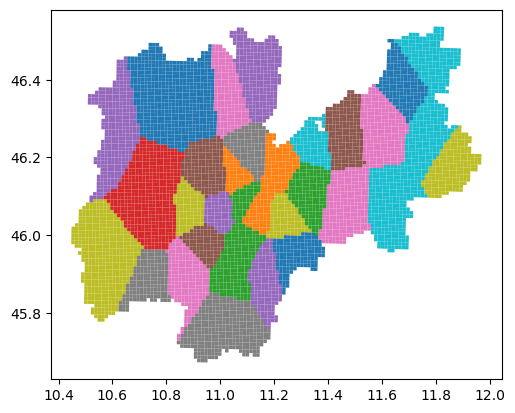

In [17]:
df_grid.plot('station')

Unisco ora i dati sui consumi con i dati del meteo, usano df_grid come mezzo intermedio per fornire chiavi comuni tra i due database da usare

In [18]:
consumi_meteo_df = consumi.copy()

consumi_meteo_df = consumi.merge(df_grid, how='left', on='cellId').copy()   # unisco dfgrid in modo da avere informazioni
                                                                            # sulle stazioni meteo associate ad ogni cellid

consumi_meteo_df.drop(columns=['geometry_y', 'center_y'], inplace=True)     # elimino colonne duplicate

consumi_meteo_df = consumi_meteo_df.rename(columns={'geometry_x':'geometry', 'center_x':'center'}) # rinomino colonne

consumi_meteo_df = gpd.GeoDataFrame(consumi_meteo_df, geometry='geometry')  # trasformo i dati meteo da df a gdf


# metto ora insieme i dati meteo con i dati dei consumi
consumi_meteo_df = consumi_meteo_df.merge(dati_meteo_generali, how='left', on=['station', 'elevation', 'month', 'day', 'hour', 'week']).copy()

consumi_meteo_df.drop(columns='POSIZIONE', inplace=True)                    # elimino la colonna ausiliaria della posizione

consumi_meteo_df.to_pickle('consumi_meteo.pkl')                             # salvo il tutto in un file pickle

consumi_meteo_df

,cellId,geometry,center,LINESET,NR_UBICAZIONI,month,day,hour,week,CONSUMI,PRO_COM,SEZ,COD_LOC,TIPO_LOC,station,elevation,TEMPERATURA,PIOGGIA,precipitation
0,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,0,fri,0.543304,22007,53,40001,4,T0405,170,12.075000,0.0,False
1,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,1,fri,0.453565,22007,53,40001,4,T0405,170,10.775000,0.0,False
2,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,2,fri,0.466783,22007,53,40001,4,T0405,170,11.050000,0.0,False
3,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,3,fri,0.437217,22007,53,40001,4,T0405,170,11.000000,0.0,False
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",POINT (10.92119 45.68640),DG1031221,4,11,1,4,fri,0.442435,22007,53,40001,4,T0405,170,11.300000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705379,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,19,sun,0.807393,22039,2,40001,4,T0437,1465,-7.500000,0.0,False
3705380,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,20,sun,0.681264,22039,2,40001,4,T0437,1465,-7.850000,0.0,False
3705381,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,21,sun,0.645372,22039,2,40001,4,T0437,1465,-8.350000,0.0,False
3705382,11099,"POLYGON ((11.76477 46.51064, 11.77778 46.51033...",POINT (11.77105 46.50599),DG1013503,3,12,31,22,sun,0.583070,22039,2,40001,4,T0437,1465,-8.866667,0.0,False


I dati sulla qualità dell'aria sono troppo limitati in estensione geografica per poter essere utili nella mappa generale. Li uso quindi in mappe locali, usando i dati ISTAT per creare delle identificazioni geografiche delle località coinvolte.

Delle 5 località, 2 sono inutilizzabili: 
* la **Piana Rotaliana** perché è molto estesa e non esistono informazioni sulla posizione della/e stazione/i di rilevamento,senza contare la grossa difficoltà nello stabilire i codici che permetterebbero di identificare le celle da usare per la mappa locale;
* **Riva del Garda** perché è un comune troppo piccolo e ha una forma molto irregolare, il che rende la risultante mappa locale un'approssimazione completamente insufficiente per qualsiasi scopo.

Creo quindi una maschera usando i dati ISTAT originali e poi cerco di selezionare i dati con le stesse caratteristiche nel database dei consumi.

C:\Users\anank\AppData\Local\Temp\ipykernel_23744\3612396462.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trento_city['center'] = trento_city.centroid                                # aggiungo il centro ado ogni zona
C:\Users\anank\.conda\envs\clone_trento_sociale\lib\site-packages\geopandas\geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
C:\Users\anank\.conda\envs\clone_trento_sociale\lib\site-packages\geopandas\array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


<AxesSubplot:>

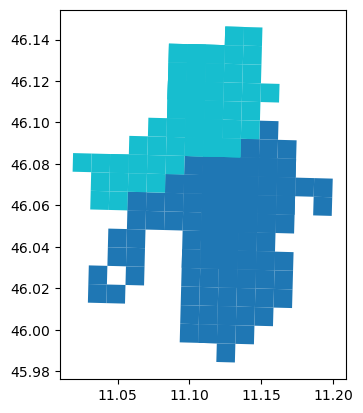

In [19]:
# Parto col comune di Trento
trento_comune = consumi_meteo_df[(consumi_meteo_df.PRO_COM==22205)].copy()  # seleziono dal df dei consumi tutte le celle
                                                                            # con il codice comune di Trento


comune_trento = dat_amm[dat_amm.PRO_COM==22205].copy()                      # faccio lo stesso con il df di ISTAT

trento_city = comune_trento[comune_trento.COD_LOC == 10018].copy()          # questo è il codic epe rla zona urbana

trento_city['center'] = trento_city.centroid                                # aggiungo il centro ado ogni zona

# per visualizzare le mappe così costruite, togliere il commento alle due seguenti righe di codice

# comune_trento.plot()
# trento_city.plot()

# a Trento ho 2 stazioni di rilevamento; divido quindi il territorio comunale tra le due identificando la sezione 
# la sezione dove sono posizionati e poi facendo una divisione in base alla distanza minima
                                                                            
via_bolzano = comune_trento[comune_trento.SEZ == 346].copy()                # posizione della stazione di via Bolzano 
# via_bolzano.plot()

via_bolzano.drop(columns='Shape_Area', inplace=True)                        # elimino delle informazioni non necessarie

via_bolzano['Stazione']='Via Bolzano'                                       # aggiungo la chiave del dataset APPA
via_bolzano

Parco_S_Chiara = trento_city[comune_trento.SEZ == 104].copy()               # posizione della stazione del parco Santa
                                                                            # Chiara e poi faccio lo stesso fatto sopra
# Parco_S_Chiara.plot()
Parco_S_Chiara.drop(columns='Shape_Area', inplace=True)
Parco_S_Chiara['Stazione']='Parco S. Chiara'


stazioni_trento = via_bolzano.append(Parco_S_Chiara).reset_index(drop=True).copy()  # unisco le due informazioni

stazioni_trento.drop(columns=['PRO_COM', 'SEZ', 'COD_LOC', 'TIPO_LOC', 'center'], inplace=True) # butto via le cose extra


trento_comune = trento_comune.sjoin_nearest(stazioni_trento).drop(columns='index_right').copy() # attacco la chiave APPA
                                                                                                # alle gdf del comune di TN
                                                                                                # in base alla distnza
                                                                                                # minore dalle due stazioni

trento_citta = trento_comune[(trento_comune.COD_LOC == 10018)].copy()       # seleziono i dati per la zona urbana

trento_comune[(trento_comune.month==11)&(trento_comune.day==1)&(trento_comune.hour==0)].plot('Stazione')

<AxesSubplot:>

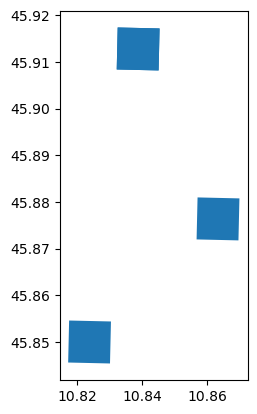

In [20]:
#faccio lo stesso per Riva del Garda, anche se dal grafico è evidente che non sono informazioni utili
comune_riva_dg = dat_amm[dat_amm.PRO_COM==22153].copy()
riva_dg = comune_riva_dg[comune_riva_dg.COD_LOC == 10003].copy()
# riva_dg.plot()

riva_del_garda_comune = consumi_meteo_df[(consumi_meteo_df.PRO_COM==22153)].copy()
riva_del_garda_comune['Stazione']='Riva del Garda'
riva_del_garda_comune[(riva_del_garda_comune.month==11)&(riva_del_garda_comune.day==1)&(riva_del_garda_comune.hour==11)].plot()

<AxesSubplot:>

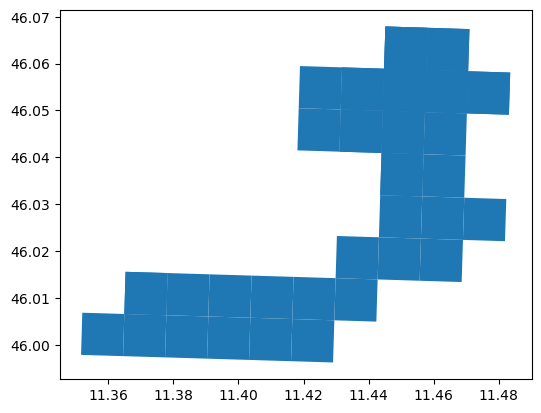

In [21]:
# uguale per il comune di Borgo; stavolta ho qualcosa con cui lavorare
comune_borgo_valsugana = dat_amm[dat_amm.PRO_COM==22022].copy()
borgo_valsugana = comune_borgo_valsugana[comune_borgo_valsugana.COD_LOC == 10001].copy()
# borgo_valsugana.plot()

borgo_valsugana_comune = consumi_meteo_df[(consumi_meteo_df.PRO_COM==22022)].copy()
borgo_valsugana_comune['Stazione']='Borgo Valsugana'
borgo_valsugana_citta = borgo_valsugana_comune[borgo_valsugana_comune.COD_LOC == 10001].copy()
borgo_valsugana_comune[(borgo_valsugana_comune.month==11)&(borgo_valsugana_comune.day==1)&(borgo_valsugana_comune.hour==11)].plot()
# borgo_valsugana_comune

<AxesSubplot:>

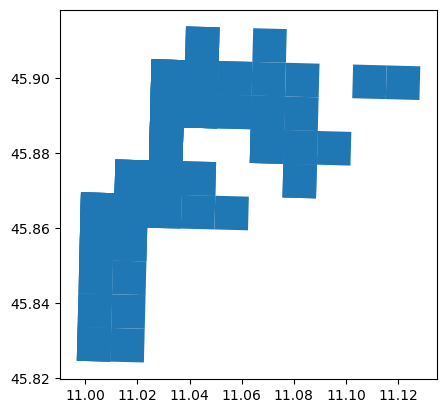

In [22]:
# infine lo faccio anche per Rovereto
comune_rovereto = dat_amm[dat_amm.PRO_COM==22161].copy()
rovereto = comune_rovereto[comune_rovereto.COD_LOC == 10002].copy()
# comune_rovereto.plot()

rovereto_comune = consumi_meteo_df[(consumi_meteo_df.PRO_COM==22161)].copy()
rovereto_comune['Stazione']='Rovereto'
rovereto_citta = rovereto_comune[rovereto_comune.COD_LOC == 10002].copy()
rovereto_comune[(rovereto_comune.month==11)&(rovereto_comune.day==1)&(rovereto_comune.hour==11)].plot()
# rovereto_comune

In [23]:
# per comodità creo una lista dei nomi da usare come chiave
lista_nomi = ['Via Bolzano',
 'Riva del Garda',
 'Rovereto',
 'Parco S. Chiara',
 'Borgo Valsugana']
lista_nomi

['Via Bolzano',
 'Riva del Garda',
 'Rovereto',
 'Parco S. Chiara',
 'Borgo Valsugana']

In [24]:
# carico i dati dal file; specifico il codec da usare perché il carattere µ crea grossi problemi altrimenti
appa = gpd.read_file(data_path / files['appa'], encoding='latin-1')

# elimino la colonna geometria, visto che è vuota
appa.drop(columns='geometry', inplace=True)

# le ore nel resto dei databse usano la convenzione 0-23, in questo 1-24: faccio -1 per rimediare. Inoltre sono in formato
# stringa, quindi faccio il casting a int
appa.Ora = appa.Ora.apply(int)-1

# rinomino le colonne perché abbiano lo stesso nome che mi aspetterei
appa.rename(columns={'Data':'DATA', 'Ora':'hour'}, inplace=True)

# CHI HA SALVATO I DATI HA ACCIDENTALMENTE INSERITO UN (1) SPAZIO DOPO SOLO UNO DEI - SEPARATORI, LO ELIMINO
appa['DATA'] = appa['DATA'].str.replace(' ', '')
appa

,Stazione,Inquinante,DATA,hour,Valore,Unità di misura
0,Parco S. Chiara,PM10,2013-11-01,0,23,µg/mc
1,Parco S. Chiara,PM10,2013-11-01,1,25,µg/mc
2,Parco S. Chiara,PM10,2013-11-01,2,23,µg/mc
3,Parco S. Chiara,PM10,2013-11-01,3,21,µg/mc
4,Parco S. Chiara,PM10,2013-11-01,4,20,µg/mc
...,...,...,...,...,...,...
31825,Riva del Garda,Ozono,2013-12-31,19,6,µg/mc
31826,Riva del Garda,Ozono,2013-12-31,20,6,µg/mc
31827,Riva del Garda,Ozono,2013-12-31,21,6,µg/mc
31828,Riva del Garda,Ozono,2013-12-31,22,7,µg/mc


In [25]:
appa_ausiliario = appa.copy()                                   # creo copia dei dati originali

SplitDate2(appa_ausiliario)                                     # converto la data nella modalità usata finora

appa_ausiliario.Valore.replace('n.d.', np.nan, inplace=True)    # al posto dei dati mancanti è stata inserita una stringa
                                                                # che dice 'n.d.': sostituisco con un NaN

appa_ausiliario.Valore = appa_ausiliario.Valore.apply(float)    # i dati sono sotto forma di stringhe: casto a float

#converto i dati in g/mc così da poter buttare via la colonna delle unità di misura
appa_ausiliario.loc[(appa_ausiliario['Unità di misura']=='µg/mc'), 'Valore'] = appa_ausiliario.loc[(appa_ausiliario['Unità di misura']=='µg/mc'), 'Valore'].apply(microgrammi)
appa_ausiliario.loc[(appa_ausiliario['Unità di misura']=='mg/mc'), 'Valore'] = appa_ausiliario.loc[(appa_ausiliario['Unità di misura']=='mg/mc'), 'Valore'].apply(milligrammi)
appa_ausiliario.drop(columns='Unità di misura', inplace=True)

# ecco i dati sulla qualtà dell'aria sistemati in modo che possano essere usati con il resto dei dati
appa_ausiliario

,Stazione,Inquinante,hour,Valore,month,day,week
0,Parco S. Chiara,PM10,0,0.000023,11,1,fri
1,Parco S. Chiara,PM10,1,0.000025,11,1,fri
2,Parco S. Chiara,PM10,2,0.000023,11,1,fri
3,Parco S. Chiara,PM10,3,0.000021,11,1,fri
4,Parco S. Chiara,PM10,4,0.000020,11,1,fri
...,...,...,...,...,...,...,...
31825,Riva del Garda,Ozono,19,0.000006,12,31,sun
31826,Riva del Garda,Ozono,20,0.000006,12,31,sun
31827,Riva del Garda,Ozono,21,0.000006,12,31,sun
31828,Riva del Garda,Ozono,22,0.000007,12,31,sun


In [26]:
appa_ausiliario1 = appa_ausiliario.copy()

schiara  = appa_ausiliario1[appa_ausiliario1.Stazione == 'Parco S. Chiara'].reset_index(drop=True).copy()
bolzano  = appa_ausiliario1[appa_ausiliario1.Stazione == 'Via Bolzano'].reset_index(drop=True).copy()
rovereto = appa_ausiliario1[appa_ausiliario1.Stazione == 'Rovereto'].reset_index(drop=True).copy()
borgo    = appa_ausiliario1[appa_ausiliario1.Stazione == 'Borgo Valsugana'].reset_index(drop=True).copy()

def giratore(df):
    df1 = df[df.Inquinante == 'PM10'].rename(columns={'Valore':'PM10'}).drop(columns='Inquinante').copy()
    df2 = df[df.Inquinante == 'PM2.5'].rename(columns={'Valore':'PM2.5'}).drop(columns='Inquinante').copy()
    df3 = df[df.Inquinante == 'Biossido di Azoto'].rename(columns={'Valore':'Biossido di Azoto'}).drop(columns='Inquinante').copy()
    df4 = df[df.Inquinante == 'Ozono'].rename(columns={'Valore':'Ozono'}).drop(columns='Inquinante').copy()
    df5 = df[df.Inquinante == 'Biossido Zolfo'].rename(columns={'Valore':'Biossido Zolfo'}).drop(columns='Inquinante').copy()
    df6 = df[df.Inquinante == 'Ossido di Carbonio'].rename(columns={'Valore':'Ossido di Carbonio'}).drop(columns='Inquinante').copy()

    df1 = df1.merge(df2, how='left', on=['Stazione', 'month', 'day', 'hour', 'week']).copy()
    df1 = df1.merge(df3, how='left', on=['Stazione', 'month', 'day', 'hour', 'week']).copy()
    df1 = df1.merge(df4, how='left', on=['Stazione', 'month', 'day', 'hour', 'week']).copy()
    df1 = df1.merge(df5, how='left', on=['Stazione', 'month', 'day', 'hour', 'week']).copy()
    df1 = df1.merge(df6, how='left', on=['Stazione', 'month', 'day', 'hour', 'week']).copy()
    
    return df1

schiara  = giratore(schiara)
bolzano  = giratore(bolzano)
rovereto = giratore(rovereto)
borgo    = giratore(borgo)

appa_ausiliario1 = schiara.append(bolzano).append(rovereto).append(borgo)
appa_ausiliario1

,Stazione,hour,PM10,month,day,week,PM2.5,Biossido di Azoto,Ozono,Biossido Zolfo,Ossido di Carbonio
0,Parco S. Chiara,0,0.000023,11,1,fri,0.000014,0.000038,0.000002,0.000001,NaN
1,Parco S. Chiara,1,0.000025,11,1,fri,0.000014,0.000033,0.000002,0.000001,NaN
2,Parco S. Chiara,2,0.000023,11,1,fri,0.000013,0.000036,0.000002,0.000002,NaN
3,Parco S. Chiara,3,0.000021,11,1,fri,0.000013,0.000032,0.000002,0.000001,NaN
4,Parco S. Chiara,4,0.000020,11,1,fri,0.000012,0.000029,0.000002,0.000001,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1454,Borgo Valsugana,19,0.000050,12,31,sun,0.000028,0.000049,0.000006,NaN,NaN
1455,Borgo Valsugana,20,0.000052,12,31,sun,0.000029,0.000046,0.000005,NaN,NaN
1456,Borgo Valsugana,21,0.000039,12,31,sun,0.000023,0.000043,0.000004,NaN,NaN
1457,Borgo Valsugana,22,0.000041,12,31,sun,0.000025,0.000039,0.000004,NaN,NaN


In [27]:
# unisco i dati APPA con i dati consumi e meteo di Trento

# per alleggerire il carico, preseleziono SOLO le righe che siano relative o a v.B. o a P.S.C.
appa_trento = appa_ausiliario1[(appa_ausiliario1.Stazione=='Parco S. Chiara')|(appa_ausiliario1.Stazione=='Via Bolzano')].copy()

# faccio l'effettiva fusione dei dati
appa_trento = trento_comune.merge(appa_trento, how='left', on=['Stazione', 'month', 'day', 'hour', 'week'])
# sistemo l'indice
appa_trento.reset_index(drop=True)

# salvo il gdf ottenuto in un file pickle
appa_trento.to_pickle('trento.pkl')

appa_trento

,cellId,geometry,center,LINESET,NR_UBICAZIONI,month,day,hour,week,CONSUMI,...,TEMPERATURA,PIOGGIA,precipitation,Stazione,PM10,PM2.5,Biossido di Azoto,Ozono,Biossido Zolfo,Ossido di Carbonio
0,4148,"POLYGON ((11.11904 45.99342, 11.13194 45.99318...",POINT (11.12532 45.98881),DG1011930,14,11,1,0,fri,2.508737,...,11.950,0.0,False,Parco S. Chiara,0.000023,0.000014,0.000038,0.000002,0.000001,NaN
1,4148,"POLYGON ((11.11904 45.99342, 11.13194 45.99318...",POINT (11.12532 45.98881),DG1011930,14,11,1,1,fri,2.222950,...,11.075,0.0,False,Parco S. Chiara,0.000025,0.000014,0.000033,0.000002,0.000001,NaN
2,4148,"POLYGON ((11.11904 45.99342, 11.13194 45.99318...",POINT (11.12532 45.98881),DG1011930,14,11,1,2,fri,2.217318,...,11.300,0.0,False,Parco S. Chiara,0.000023,0.000013,0.000036,0.000002,0.000002,NaN
3,4148,"POLYGON ((11.11904 45.99342, 11.13194 45.99318...",POINT (11.12532 45.98881),DG1011930,14,11,1,3,fri,2.175084,...,11.325,0.0,False,Parco S. Chiara,0.000021,0.000013,0.000032,0.000002,0.000001,NaN
4,4148,"POLYGON ((11.11904 45.99342, 11.13194 45.99318...",POINT (11.12532 45.98881),DG1011930,14,11,1,4,fri,2.137073,...,11.500,0.0,False,Parco S. Chiara,0.000020,0.000012,0.000029,0.000002,0.000001,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379171,6138,"POLYGON ((11.13784 46.14608, 11.15078 46.14584...",POINT (11.14413 46.14146),DG1026026,16,12,31,19,sun,2.925878,...,-1.050,0.0,False,Via Bolzano,0.000056,NaN,0.000091,NaN,NaN,0.0012
379172,6138,"POLYGON ((11.13784 46.14608, 11.15078 46.14584...",POINT (11.14413 46.14146),DG1026026,16,12,31,20,sun,2.445878,...,-1.950,0.0,False,Via Bolzano,0.000054,NaN,0.000094,NaN,NaN,0.0012
379173,6138,"POLYGON ((11.13784 46.14608, 11.15078 46.14584...",POINT (11.14413 46.14146),DG1026026,16,12,31,21,sun,2.193262,...,-3.050,0.0,False,Via Bolzano,0.000041,NaN,0.000071,NaN,NaN,0.0009
379174,6138,"POLYGON ((11.13784 46.14608, 11.15078 46.14584...",POINT (11.14413 46.14146),DG1026026,16,12,31,22,sun,1.965018,...,-3.450,0.0,False,Via Bolzano,0.000032,NaN,0.000054,NaN,NaN,0.0007


In [28]:
# unisco i dati APPA con i dati consumi e meteo di Rovereto, vedi sopra per commenti
appa_rovereto = appa_ausiliario1[(appa_ausiliario1.Stazione=='Rovereto')].copy()

appa_rovereto = rovereto_comune.merge(appa_rovereto, how='left', on=['Stazione', 'month', 'day', 'hour', 'week'])
appa_rovereto.reset_index(drop=True)

appa_rovereto.to_pickle('rovereto.pkl')

appa_rovereto

,cellId,geometry,center,LINESET,NR_UBICAZIONI,month,day,hour,week,CONSUMI,...,TEMPERATURA,PIOGGIA,precipitation,Stazione,PM10,PM2.5,Biossido di Azoto,Ozono,Biossido Zolfo,Ossido di Carbonio
0,2033,"POLYGON ((10.99707 45.83361, 11.00994 45.83338...",POINT (11.00335 45.82900),DG1003116,10,11,1,0,fri,1.693033,...,12.075,0.0,False,Rovereto,0.000018,0.000012,0.000019,0.000012,NaN,NaN
1,2033,"POLYGON ((10.99707 45.83361, 11.00994 45.83338...",POINT (11.00335 45.82900),DG1003116,10,11,1,1,fri,1.637705,...,10.775,0.0,False,Rovereto,0.000019,0.000013,0.000020,0.000011,NaN,NaN
2,2033,"POLYGON ((10.99707 45.83361, 11.00994 45.83338...",POINT (11.00335 45.82900),DG1003116,10,11,1,2,fri,1.637705,...,11.050,0.0,False,Rovereto,0.000019,0.000013,0.000021,0.000009,NaN,NaN
3,2033,"POLYGON ((10.99707 45.83361, 11.00994 45.83338...",POINT (11.00335 45.82900),DG1003116,10,11,1,3,fri,1.637705,...,11.000,0.0,False,Rovereto,0.000020,0.000014,0.000025,0.000005,NaN,NaN
4,2033,"POLYGON ((10.99707 45.83361, 11.00994 45.83338...",POINT (11.00335 45.82900),DG1003116,10,11,1,4,fri,1.632172,...,11.300,0.0,False,Rovereto,0.000022,0.000015,0.000032,0.000002,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140539,3091,"POLYGON ((11.06441 45.91342, 11.07729 45.91319...",POINT (11.07068 45.90881),DG1003301,3,12,31,19,sun,1.673255,...,0.350,0.0,False,Rovereto,0.000013,0.000012,0.000031,0.000019,NaN,NaN
140540,3091,"POLYGON ((11.06441 45.91342, 11.07729 45.91319...",POINT (11.07068 45.90881),DG1003301,3,12,31,20,sun,1.606543,...,-0.150,0.0,False,Rovereto,0.000014,0.000012,0.000029,0.000019,NaN,NaN
140541,3091,"POLYGON ((11.06441 45.91342, 11.07729 45.91319...",POINT (11.07068 45.90881),DG1003301,3,12,31,21,sun,1.518929,...,-0.550,0.0,False,Rovereto,0.000017,0.000015,0.000035,0.000017,NaN,NaN
140542,3091,"POLYGON ((11.06441 45.91342, 11.07729 45.91319...",POINT (11.07068 45.90881),DG1003301,3,12,31,22,sun,1.481994,...,-0.600,0.0,False,Rovereto,0.000016,0.000014,0.000033,0.000016,NaN,NaN


In [29]:
# faccio infine lo stesso per Borgo Valsugana
appa_borgo_valsugana = appa_ausiliario1[(appa_ausiliario1.Stazione=='Borgo Valsugana')].copy()
appa_borgo_valsugana = borgo_valsugana_comune.merge(appa_borgo_valsugana, how='left', on=['Stazione', 'month', 'day', 'hour', 'week'])
appa_borgo_valsugana.reset_index(drop=True)

appa_borgo_valsugana.to_pickle('borgo_valsugana.pkl')

appa_borgo_valsugana

,cellId,geometry,center,LINESET,NR_UBICAZIONI,month,day,hour,week,CONSUMI,...,TEMPERATURA,PIOGGIA,precipitation,Stazione,PM10,PM2.5,Biossido di Azoto,Ozono,Biossido Zolfo,Ossido di Carbonio
0,4400,"POLYGON ((11.35204 46.00687, 11.36495 46.00660...",POINT (11.35831 46.00224),DG1002021,2,11,1,0,fri,0.057483,...,8.925,0.0,False,Borgo Valsugana,0.000019,0.000012,0.000021,0.000002,NaN,NaN
1,4400,"POLYGON ((11.35204 46.00687, 11.36495 46.00660...",POINT (11.35831 46.00224),DG1002021,2,11,1,1,fri,0.042293,...,9.100,0.0,False,Borgo Valsugana,0.000018,0.000011,0.000018,0.000002,NaN,NaN
2,4400,"POLYGON ((11.35204 46.00687, 11.36495 46.00660...",POINT (11.35831 46.00224),DG1002021,2,11,1,2,fri,0.042777,...,9.050,0.0,False,Borgo Valsugana,0.000019,0.000012,0.000019,0.000002,NaN,NaN
3,4400,"POLYGON ((11.35204 46.00687, 11.36495 46.00660...",POINT (11.35831 46.00224),DG1002021,2,11,1,3,fri,0.036485,...,8.800,0.0,False,Borgo Valsugana,0.000020,0.000011,0.000017,0.000002,NaN,NaN
4,4400,"POLYGON ((11.35204 46.00687, 11.36495 46.00660...",POINT (11.35831 46.00224),DG1002021,2,11,1,4,fri,0.035294,...,8.575,0.0,False,Borgo Valsugana,0.000021,0.000013,0.000018,0.000002,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64411,5227,"POLYGON ((11.45807 46.06764, 11.47099 46.06736...",POINT (11.46433 46.06300),DG1010902,75,12,31,19,sun,20.891788,...,-1.425,0.0,False,Borgo Valsugana,0.000050,0.000028,0.000049,0.000006,NaN,NaN
64412,5227,"POLYGON ((11.45807 46.06764, 11.47099 46.06736...",POINT (11.46433 46.06300),DG1010902,75,12,31,20,sun,18.480718,...,-2.050,0.0,False,Borgo Valsugana,0.000052,0.000029,0.000046,0.000005,NaN,NaN
64413,5227,"POLYGON ((11.45807 46.06764, 11.47099 46.06736...",POINT (11.46433 46.06300),DG1010902,75,12,31,21,sun,16.712932,...,-2.350,0.0,False,Borgo Valsugana,0.000039,0.000023,0.000043,0.000004,NaN,NaN
64414,5227,"POLYGON ((11.45807 46.06764, 11.47099 46.06736...",POINT (11.46433 46.06300),DG1010902,75,12,31,22,sun,15.254322,...,-2.425,0.0,False,Borgo Valsugana,0.000041,0.000025,0.000039,0.000004,NaN,NaN


In [30]:
# precip       = gpd.read_file(data_path / files['precip'])
# # # precip_avail = gpd.read_file(data_path / files['precip-avail'])

# precip.drop(columns='geometry', inplace=True)
# # # precip_avail.drop(columns='geometry', inplace=True)

# # # pioggia = precip_avail.merge(precip, how='left', on='DATA')

# # SplitDate3(pioggia)

# # pioggia.drop(pioggia[pioggia.cellId.isna()].index, inplace=True)
# # pioggia.reset_index(drop=True, inplace=True)
# # pioggia.drop(columns=['DATA', 'year', 'availability'], inplace=True)
# # pioggia.cellId = pioggia.cellId.astype(np.dtype("int16"))

# precip

In [31]:
# pioggia = precip.copy()
# pioggia.cellId = pioggia.cellId.astype(np.dtype("int16"))
# pioggia.precipitations = pioggia.precipitations.astype(np.dtype("int8"))
# SplitDate3(pioggia)
# pioggia = pioggia.groupby(['cellId', 'month', 'day', 'hour', 'week'], as_index=False).mean()
# pioggia.drop(columns='minute', inplace=True)

# megaset = consumi_meteo_df.merge(pioggia, how='left', on=['cellId', 'month', 'day', 'hour', 'week'])
# # megaset.drop(columns = 'week_y', inplace=True)
# # megaset.rename({'week_x':'week'}, inplace=True)
# megaset